In [1]:
# Notebook / Runpod setup, safe to ignore
%pip install matplotlib accelerate datasets einops huggingface-hub jaxtyping natsort simple-parsing triton transformers gguf sentencepiece scikit-learn seaborn
%pip install -U safetensors>=0.4.3
%pip install git+https://github.com/EleutherAI/sae.git


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/EleutherAI/sae.git to /tmp/pip-req-build-tp2tvuiy
  Running command git clone --filter=blob:none --quiet https://github.com/EleutherAI/sae.git /tmp/pip-req-build-tp2tvuiy
  Resolved https://github.com/EleutherAI/sae.git to commit 68f5db6b52a02606b4e9ac0f1496fa3c4f51ce23
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.insert(0, "/workspace/experiments")
os.environ["HF_HOME"] = "/workspace/experiments/hf"

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
import json

import tqdm
import torch
import numpy as np

from repeng import ControlVector, ControlModel, DatasetEntry
import repeng.saes

# Model loading

We load the base model (for best compatibility with the Eleuther SAE, which was trained on 8B-base), the instruct model (to demonstrate vector transfer later!), and the Eleuther SAE. To save memory and make everything fit in an A100, we're only going to load a subset of the SAE layers. <small>(Between these models, we're going to end up with ~70GB VRAM usage. This notebook ran on an A100 SXM)</small>

In [6]:
from huggingface_hub import snapshot_download
import json
import os

# Download the dataset directory
dataset_dir = snapshot_download(repo_id="EleutherAI/auto_interp_explanations", repo_type="dataset")

# Specify the directory you want to search, appending '/262k/res'
directory = os.path.join(dataset_dir, "Llama/262k/res")

# Initialize a dictionary to store data
data_dict = {}

# Walk through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        file_path = os.path.join(root, file)
        print(f"Loading file: {file_path}")
        
        # Load the file based on its extension
        try:
            base_name = file_path.replace('/', '.').split('.')[-2]  # Get last part before extension
            
            if file.endswith('.json'):
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    data_dict[base_name] = data  # Use base filename as key
            elif file.endswith('.txt'):
                with open(file_path, 'r') as f:
                    data = f.read()
                    data_dict[base_name] = data  # Use base filename as key
            # Add more conditions for other file types if needed
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")

Fetching 541 files:   0%|          | 0/541 [00:00<?, ?it/s]

scores/gemma/131k/res/fuzz_layer_11.json:   0%|          | 0.00/1.88M [00:00<?, ?B/s]

(…)ores/gemma/131k/res/recall_layer_11.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

Loading file: /workspace/experiments/hf/hub/datasets--EleutherAI--auto_interp_explanations/snapshots/c2511d146a5a765d183a40ad888bb3b2037dd352/Llama/262k/res/model.layers.23_feature.json
Loading file: /workspace/experiments/hf/hub/datasets--EleutherAI--auto_interp_explanations/snapshots/c2511d146a5a765d183a40ad888bb3b2037dd352/Llama/262k/res/model.layers.29_feature.json


In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import gc
torch.cuda.empty_cache()

# Collect garbage
gc.collect()

# Force CUDA to sync
torch.cuda.synchronize()

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")
tokenizer.pad_token_id = tokenizer.eos_token_id

control_layers = [24, 30]
target_layer = 24
#control_layers = list(range(target_layer, target_layer+1))

base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    torch_dtype="auto").to(
    torch.device("cuda:0"))
base_model = ControlModel(base_model, control_layers)

instruct_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    torch_dtype="auto").to(
    torch.device("cuda:0"))
instruct_model = ControlModel(instruct_model, control_layers)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
sae = repeng.saes.from_eleuther(device="cuda:1", layers=control_layers, repo='EleutherAI/sae-llama-3.1-8b-64x', revision='cca69a815bf3e8ce60f3ed19d197cd6e4e3662cc')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:42<00:00, 21.03s/it]


In [12]:
# repeng dataloading / template boilerplate
with open("/workspace/experiments/notebooks/data/all_truncated_outputs.json") as f:
    output_suffixes = json.load(f)
truncated_output_suffixes = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes)
    for i in range(1, len(tokens))
]
truncated_output_suffixes_512 = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes[:512])
    for i in range(1, len(tokens))
]

with open("/workspace/experiments/notebooks/data/true_facts.json") as f:
    fact_suffixes = json.load(f)
truncated_fact_suffixes = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in fact_suffixes)
    for i in range(1, len(tokens) - 5)
]

# base model so roll our own instruct template
# TEMPLATE = """{persona} is talking to the user.

# User: {user_msg}

# AI: {prefill}"""
# TEMPLATE = """<|start_header_id|>system<|end_header_id|>
# {persona} is talking to the user.<|eot_id|><|start_header_id|>user<|end_header_id|>

# {user_msg}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

# {prefill}"""
TEMPLATE = """{persona}. {prefill}"""

def template_parse(resp: str) -> tuple[str, str, str]:
    if "<|start_header_id|>user" in resp:
        persona = ""
        _, rest = resp.split("<|start_header_id|>user<|end_header_id|>")
        user, assistant = rest.split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")
    elif "User:" in resp:
        persona, rest = resp.split("\n\nUser: ", 1)
        user, assistant = rest.split("\n\nAI: ", 1)
    else:
        persona = ""
        user = ""
        assistant = resp

    return (persona.strip(), user.strip(), assistant.strip())

def make_dataset(
    persona_template: str,
    positive_personas: list[str],
    negative_personas: list[str],
    user_msg: str,
    suffix_list: list[str]
) -> list[DatasetEntry]:
    dataset = []
    for suffix in suffix_list:
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            pos = persona_template.format(persona=positive_persona)
            neg = persona_template.format(persona=negative_persona)
            dataset.append(
                DatasetEntry(
                    positive=TEMPLATE.format(persona=pos, user_msg=user_msg, prefill=suffix),
                    negative=TEMPLATE.format(persona=neg, user_msg=user_msg, prefill=suffix),
                )
            )
    return dataset

from IPython.display import display, HTML
from transformers import TextStreamer

class HTMLStreamer(TextStreamer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.display_handle = display(display_id=True)
        self.full_text = ""

    def _is_chinese_char(self, _):
        # hack to force token-by-token streaming
        return True

    def on_finalized_text(self, text: str, stream_end: bool = False):
        self.full_text += text
        persona, user, assistant = template_parse(self.full_text)
        html = HTML(f"""
        <div style='border: 1px solid black; border-radius: 5px; margin-bottom: 5px; padding: 5px;'>
            <strong>persona</strong>
            <p>{persona}</p>
            <strong>user</strong>
            <p>{user}</p>
            <strong>assistant</strong>
            <p>{assistant}</p>
        </div>
        """)
        self.display_handle.update(html)

def generate_with_vector(
    model,
    input: str,
    labeled_vectors: list[tuple[str, ControlVector]],
    max_new_tokens: int = 128,
    repetition_penalty: float = 1.1,
    show_baseline: bool = False,
    temperature: float = 0.7,
):
    input_ids = tokenizer(input, return_tensors="pt").to(model.device)
    settings = {
        "pad_token_id": tokenizer.eos_token_id, # silence warning
        #"do_sample": False, # temperature=0
        "temperature": temperature,
        "max_new_tokens": max_new_tokens,
        "repetition_penalty": repetition_penalty,
    }

    def gen(label):
        display(HTML(f"<h3>{label}</h3>"))
        output = model.generate(streamer=HTMLStreamer(tokenizer), **input_ids, **settings)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        # perplexity = calculate_perplexity(model, tokenizer, generated_text)
        # display(HTML(f"<p>Perplexity: {perplexity:.2f}</p>"))
        print(generated_text)

    if show_baseline:
        model.reset()
        gen("baseline")
    for label, vector in labeled_vectors:
        model.set_control(vector)
        gen(label)
    model.reset()

# Training the vectors
Here I train 3 vectors:
* A regular control vector, for comparison.
* An SAE control vector. This is conceptually very similar to how a normal control vector is trained, but we do it over the SAE's feature space instead of activation space, and then transform back to activation space at the end so it can be used the same as a regular control vector.
* An "undecoded" SAE control vector, which skips the final transformation back to the model's activation space, and so will have raw SAE features instead. This is useful for visualizations / interp, we'll play with it later.

In [13]:
bridge_dataset = make_dataset(
    "{persona}",
    ["I am talking about the Golden Gate Bridge in San Francisco, California"],
    ["I am talking about whatever I want"],
    "",
    truncated_output_suffixes,
)

# bridge_dataset = make_dataset(
#     "{persona}",
#     ["as a nice person"],
#     ["as a mean person"],
#     "Who are you?",
#     truncated_output_suffixes,
# )


# happy_dataset = make_dataset(
#     "{persona}",
#     ["Creative AI"],
#     ["Boring AI"],
#     "Write something",
#     truncated_output_suffixes,
# )

instruct_model.reset()
base_model.reset()
# bridge_vector_no_sae = ControlVector.train(
#     base_model,
#     tokenizer,
#     bridge_dataset,
#     batch_size=32,
#     method="pca_center"
# )
# Create bridge vector using SAE topk features
bridge_vector_sae = ControlVector.train_with_sae(
    base_model,
    tokenizer,
    sae,
    bridge_dataset,
    batch_size=32,
    method="sae_topk",  # Use new topk method
    k=100,  # Keep top 100 SAE features
    hidden_layers=control_layers
)
# bridge_vector_sae_undecoded = ControlVector.train_with_sae(
#     base_model,
#     tokenizer,
#     sae,
#     bridge_dataset,
#     batch_size=32,
#     method="pca_center",
#     decode=False,
#     hidden_layers=control_layers
# )

generating tokens:   0%|          | 0/74 [00:00<?, ?it/s]

sae decoding: 100%|██████████| 2/2 [00:00<00:00, 63.85it/s]


In [14]:
import torch
import numpy as np

def bytes_to_mb(x):
    return int(x / 1024 / 1024)

def get_gpu_memory(gpu_id):
    total = bytes_to_mb(torch.cuda.get_device_properties(gpu_id).total_memory)
    allocated = bytes_to_mb(torch.cuda.memory_allocated(gpu_id))
    cached = bytes_to_mb(torch.cuda.memory_reserved(gpu_id))
    free = total - allocated - cached
    return total, allocated, cached, free

print("GPU Memory Usage:")
print("-----------------")

for i in range(torch.cuda.device_count()):
    total, allocated, cached, free = get_gpu_memory(i)
    print(f"GPU {i}:")
    print(f"  Total memory:     {total} MB")
    print(f"  Allocated memory: {allocated} MB ({allocated/total:.1%})")
    print(f"  Cached memory:    {cached} MB ({cached/total:.1%})")
    print(f"  Free memory:      {free} MB ({free/total:.1%})")
    print()

GPU Memory Usage:
-----------------
GPU 0:
  Total memory:     48669 MB
  Allocated memory: 30641 MB (63.0%)
  Cached memory:    31330 MB (64.4%)
  Free memory:      -13302 MB (-27.3%)

GPU 1:
  Total memory:     48669 MB
  Allocated memory: 8201 MB (16.9%)
  Cached memory:    16388 MB (33.7%)
  Free memory:      24080 MB (49.5%)



In [15]:
print(len(bridge_dataset), '\n', bridge_dataset[0])


1170 
 DatasetEntry(positive='I am talking about the Golden Gate Bridge in San Francisco, California. That', negative='I am talking about whatever I want. That')


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import Counter
import math
import torch.nn.functional as F

SKIP_FACTOR = 1

def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    probabilities = [count / total_tokens for count in token_counts.values()]
    entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    max_entropy = math.log2(len(token_counts))
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    return normalized_entropy

def calculate_adjusted_perplexity(perplexity, sequence, beta=5):
    norm_entropy = calculate_entropy(sequence.split())
    adjusted_perplexity = perplexity * (1 + beta * ((1 - norm_entropy)**2))
    return adjusted_perplexity

def calculate_perplexity(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        perplexity = torch.exp(loss).item()
    return perplexity

def calculate_sequence_probability(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        
    log_probs = F.log_softmax(logits, dim=-1)
    
    sequence_prob = 0.0  # Start with 0 since we're adding logs
    for i in range(input_ids.size(1)):
        token_id = input_ids[0, i].item()
        token_log_prob = log_probs[0, i, token_id].item()
        sequence_prob += token_log_prob  # Add instead of multiply
    
    return sequence_prob/input_ids.size(1)  # This will be the avg log probability

def generate_sequence(model, input_ids, vector, coeff, max_new_tokens):
    model.reset()
    model.set_control(coeff * vector)
    settings = {
        "pad_token_id": tokenizer.eos_token_id,
        "temperature": 1e-6,
        "max_new_tokens": max_new_tokens,
        #"repetition_penalty": 1,
    }
    with torch.no_grad():  # <-- Add this line
        output = model.generate(**input_ids, **settings)
    return output[0]

def calculate_perplexity_for_each_token(model, sequence):
    model.reset()
    perplexities = []
    for i in range(1, len(sequence)+1, SKIP_FACTOR):
        #pplx = calculate_perplexity(model, sequence[0:i])
        pplx = calculate_sequence_probability(model, sequence[0:i])
        #pplx = calculate_adjusted_perplexity(pplx, current_text)
        perplexities.append(pplx)
    return perplexities

def calculate_perplexities_over_sequence(model, tokenizer, input_text, vector, token_count, start_coeff=0.16, iterations=20, end_coeff=1.0):
    coefficients = []
    all_perplexities = []
    outputs = []

    coeff = start_coeff
    input_ids = tokenizer(input_text, return_tensors="pt").to(model.device)
    for _ in tqdm.tqdm(range(iterations), desc="Testing coefficients"):
        #print(coeff)
        sequence = generate_sequence(model, input_ids, vector, coeff, token_count)
        perplexities = calculate_perplexity_for_each_token(model, sequence)
        
        coefficients.append(coeff)
        all_perplexities.append(perplexities)
        output = tokenizer.decode(sequence, skip_special_tokens=True)
        outputs.append(output)
        
        coeff += (end_coeff-start_coeff)/(iterations-1)
    
    return coefficients, all_perplexities, outputs

In [17]:
input_text = "I am talking about"
vector = bridge_vector_sae

token_counts = [32]  # Adjust as needed

results = {}
for token_count in token_counts:
    print(f"Calculating for {token_count} tokens...")
    coefficients, perplexities, outputs = calculate_perplexities_over_sequence(base_model, tokenizer, input_text, vector, token_count, start_coeff=0., iterations=50, end_coeff=1.5)
    results[token_count] = {'coefficients': coefficients, "perplexities": perplexities, "outputs": outputs}
    [print(x) for x in outputs]


Calculating for 32 tokens...


Testing coefficients:   0%|          | 0/50 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 50/50 [02:19<00:00,  2.80s/it]

I am talking about the 2016 version of the game. I have been playing it for a while now and I have to say that I am really enjoying it. The game
I am talking about the 2016 version of the game. I have been playing it for a while now and I am having a lot of fun. I am not sure if
I am talking about the 2016 version of the game. I have been playing it for a while now and I am having a lot of fun. I am not sure if
I am talking about the 2016 version of the game. I have been playing it for a while now and I have to say that I am really enjoying it. The game
I am talking about the 2016 version of the 2016 version of the 2016 version of the 2016 version of the 2016 version of the 
I am talking about the 2016 version of the 2016 version of the 2016 version of the 2016 version of the 2016 version of the 
I am talking about the 2016 version of the 2016 version of the 2016 version of the 2016 version of the 2016 version of the 
I am talking about the 2016 version of the 2016 version of the 2016 

In [18]:
def get_topk_features_with_values(features: np.ndarray) -> list[tuple[int, float]]:
    """Get features sorted by absolute magnitude with their indices and values.
    
    Args:
        features: Input feature vector
            
    Returns:
        List of (index, value) tuples sorted by absolute magnitude, excluding zeros
    """
    # Convert to 1D if needed
    if len(features.shape) > 1:
        features = features.squeeze()
            
    # Get non-zero indices and values
    nonzero_mask = features != 0
    nonzero_features = features[nonzero_mask]
    nonzero_indices = np.where(nonzero_mask)[0]
        
    # Create (index, value) pairs and sort by absolute magnitude
    pairs = list(zip(nonzero_indices, nonzero_features))
    sorted_pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)
    
    return sorted_pairs

In [19]:
for x in bridge_vector_sae.undecoded_directions:
    features = bridge_vector_sae.undecoded_directions[x]
    sorted_features = get_topk_features_with_values(features)
    print(f"\nLayer {x} top features:")
    for i, (idx, value) in enumerate(sorted_features):
        label = data_dict[str(x-1) + "_feature"].get(str(idx))
        print(f"{i}. {idx} {value:.6f}: {label}")


Layer 24 top features:
0. 76437 1.918504: Text related to bridges, often mentioning specific names or descriptions of bridges, and sometimes describing their features, locations, or construction.
1. 14740 1.099231: Prepositions, articles, and other function words that introduce or connect to locations, organizations, or institutions.
2. 251857 -0.779064: The extracted tokens are often function words, such as articles, conjunctions, and prepositions, that are used to connect ideas, clauses, or phrases, often indicating a contrast, addition, or a cause-and-effect relationship.
3. 109385 0.746811: A wide variety of text features, but common among them are short function words (e.g. \the\, \a\, \an\, \and\, \to\) and parts of words (e.g. \er\, \atre\, \phere\) or phrases (e.g. \on\, \in\, \to\), which seem to provide structure or connection in a sentence.
4. 172160 0.545227: The token is typically a first-person singular pronoun, often used in informal writing, particularly in personal na

In [20]:
def search_features(data_dict: dict, query: str, layer_ids: list[int] | None = None) -> dict[int, list[tuple[int, str]]]:
    """Search feature descriptions for a query string.
    
    Args:
        data_dict: Dictionary containing feature descriptions
        query: String to search for in feature descriptions
        layer_ids: Optional list of layer IDs to search. If None, searches all layers
        
    Returns:
        Dictionary mapping layer IDs to lists of (feature_id, description) tuples
        for features whose descriptions contain the query string
    """
    if layer_ids is None:
        # Get all layer IDs from data_dict keys that end with "_feature"
        layer_ids = sorted(int(k.split('_')[0]) + 1 for k in data_dict.keys() if k.endswith('_feature'))
        
    results = {}
    query = query.lower()
    
    for layer_id in layer_ids:
        # Get feature descriptions for this layer
        feature_dict = data_dict.get(f"{layer_id-1}_feature", {})
        
        # Find features whose descriptions contain the query
        matches = []
        for feature_id, desc in feature_dict.items():
            if desc and query in desc.lower():
                matches.append((int(feature_id), desc))
                
        if matches:
            results[layer_id] = matches
            
    return results

In [21]:
# Example usage:
bridge_features = search_features(data_dict, "San Francisco", layer_ids=[24, 30])
for layer_id, features in bridge_features.items():
    print(f"\nLayer {layer_id}:")
    for feature_id, desc in features:
        print(f"{feature_id}: {desc}")

# Create steering vector from search results
feature_dict = {
    layer_id: {feature_id: 1.0 for feature_id, _ in features}
    for layer_id, features in bridge_features.items()
}
#bridge_vector = sae.steer_with_features(feature_dict)


Layer 24:
8403: Common locations in the United States, particularly cities in California, such as San Francisco, San Antonio, and San Diego, or reference to the word \sane\ or \sanctuary\ in the context, but mostly locations.
27808: Geographic locations, often referring to bodies of water or areas, typically in or around the San Francisco Bay area, with a variety of suffixes.
59378: The token \Bay\ often refers to a geographical location, usually a body of water or a region, and is often used as part of a proper noun, such as \Chesapeake Bay\, \San Francisco Bay\, or \Tampa Bay\.
60282: Abbreviations for San Francisco, often used in proper nouns (team names, airport codes, etc.) or domain names.
86957: The token \san\ is often related to the word \sanctuary\, \sanctify\, \sanity\, or variations of \san\ in different contexts, such as locations (e.g. \San Francisco\), names (e.g. \Sam\), or words with \san\ as a prefix or suffix (e.g. \unsanitary\).
99071: Abbreviated geographic names,

In [19]:
sae = repeng.saes.from_eleuther(device="cuda:0", layers=control_layers, repo='EleutherAI/sae-llama-3.1-8b-64x', revision='cca69a815bf3e8ce60f3ed19d197cd6e4e3662cc')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


In [29]:
feature_dict = {
    24: {60282: 0},
    30: {47247: 1}
}

In [31]:
input_text = "I am talking about"
vector = sae.steer_with_features(feature_dict)
token_counts = [32]  # Adjust as needed

results = {}
for token_count in token_counts:
    print(f"Calculating for {token_count} tokens...")
    coefficients, perplexities, outputs = calculate_perplexities_over_sequence(base_model, tokenizer, input_text, vector, token_count, start_coeff=0., iterations=10, end_coeff=50.)
    results[token_count] = {'coefficients': coefficients, "perplexities": perplexities, "outputs": outputs}
    [print(x) for x in outputs]

Calculating for 32 tokens...


Testing coefficients: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

I am talking about the 2016 version of the game. I have been playing it for a while now and I am really enjoying it. I have been playing it for a
I am talking about the 2016 election. I am talking about the 2016 election. I am talking about the 2016 election. I am talking about the 
I am talking about the 3rd and 4th generation of the 3D printers. The 3rd generation is the one that is used in the market today.
I am talking about the 3rd and 4th generation of the 3D printers. The 3rd generation is the one that is used in the market today.
I am talking about the 3rd Mission of the Mission Impossible series. Mission Impossible 3 Mission Impossible 3 Mission Impossible 3 Mission Impossible 3 Mission Impossible 3 Mission
I am talking about the famous “Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission Mission
I am talkin

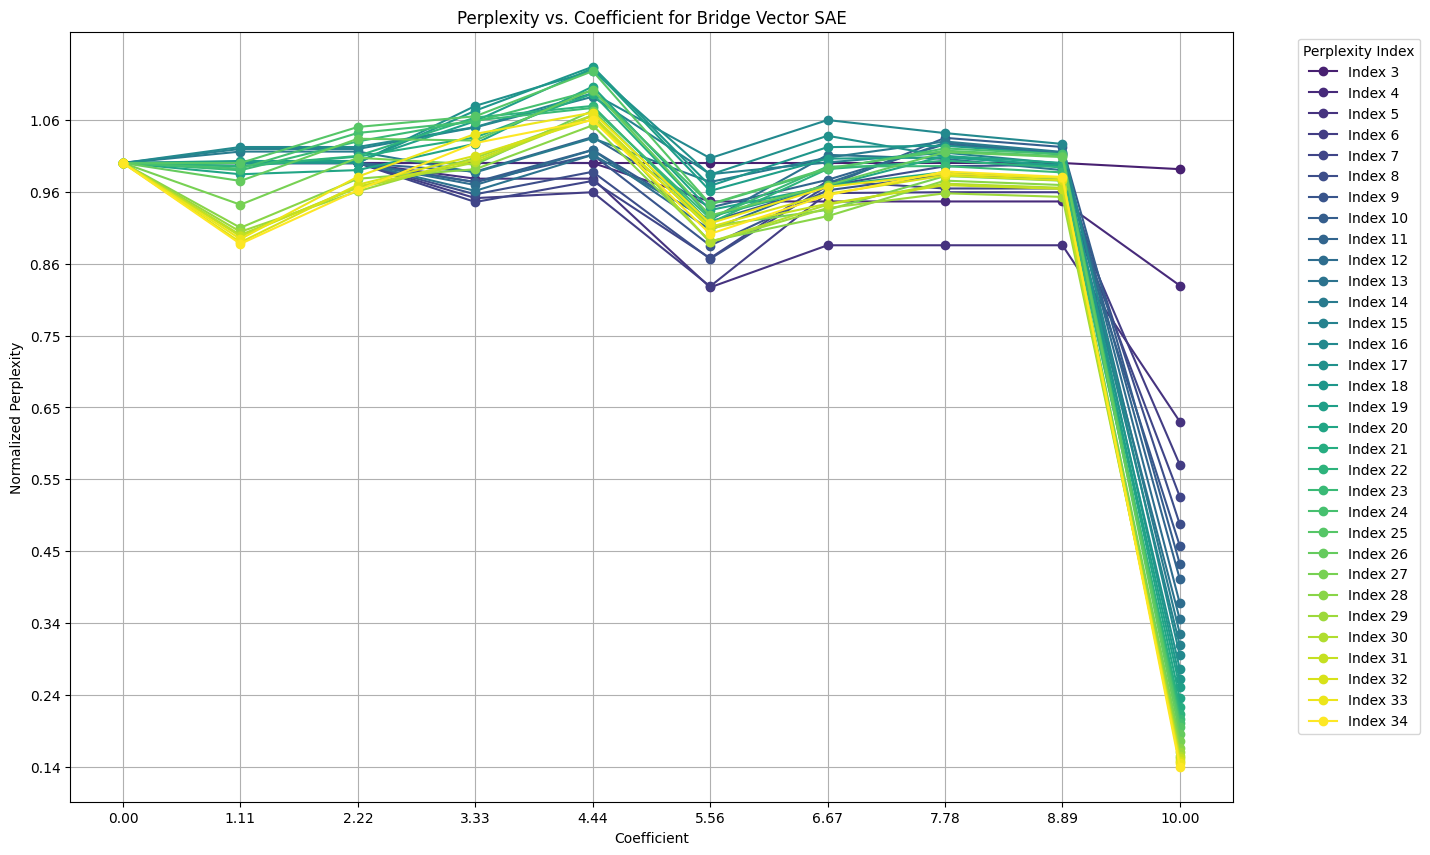

Coeff 0.0
I am a 3rd year PhD student in the Department of Mathematics at the University of Chicago. My advisor is Professor Peter Sarnak. I am interested in number


Coeff 1.1111111111111112
I am a 3rd year PhD student in the Department of Computer Science at the University of Oxford. I am a member of the Oxford Quantum Group and the Oxford Quantum


Coeff 2.2222222222222223
I am a 3rd year PhD student in the Department of Computer Science at the University of California, Davis. My research interests are in the area of machine learning and


Coeff 3.3333333333333335
I am a 30 year old woman who has been married for 10 years. I have a 7 year old daughter and a 3 year old son. I


Coeff 4.444444444444445
I am a 30-year-old woman who has been married for 10 years. My husband and I have a 4-year-old daughter. I have been a stay


Coeff 5.555555555555555
I am a native of South Carolina and a native of the South. I grew up in a small town in South Carolina and attended University of South C

In [22]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel('Coefficient')
ax.set_ylabel('Normalized Perplexity')
ax.set_title('Perplexity vs. Coefficient for Bridge Vector SAE')
ax.grid(True)

seq_length = list(results.keys()).pop()
data = results[seq_length]
coefficients = data['coefficients']
perplexities = data['perplexities']
outputs = data['outputs']

longest_output = max([len(pplx) for pplx in perplexities])

colors = plt.cm.viridis(np.linspace(0, 1, longest_output))


start_idx = longest_output-seq_length//SKIP_FACTOR
end_idx = longest_output

for idx in range(start_idx, end_idx): # Extract the perplexities for the current index across all entries
    current_perplexities = []
    for pplx in perplexities:
        if idx < len(pplx):
            current_perplexities.append(pplx[idx])
        else:
            current_perplexities.append(pplx[-1])
    
    # Normalize the perplexities
    mean_first = next(x for x in current_perplexities if not np.isnan(x))  # Mean is the first for normalization
    normalized_perplexities = [p / mean_first for p in current_perplexities]
    
    ax.plot(coefficients, normalized_perplexities, marker='o', linestyle='-', 
            color=colors[idx], label=f'Index {idx}')
    
    # Find the first coefficient where the perplexity is > 1.05x the first perplexity
    # initial_index = next((i for i, p in enumerate(normalized_perplexities) if p > 1.05), None)
    # if initial_index is not None:
    #     ax.plot(coefficients[initial_index], normalized_perplexities[initial_index], 'D', color='red', label='Initial Rise')
    #     print("Start coeff:", coefficients[initial_index])
    #     print("Outputs nearby:")
    #     if initial_index > 0:
    #         print(outputs[initial_index-1])
    #     print(outputs[initial_index])
    #     if initial_index + 1 < len(outputs):
    #         print(outputs[initial_index+1])
    #     print()
    
    # # Calculate a trailing average and find the dramatic increase
    # trailing_avg = [sum(normalized_perplexities[0:i+1]) / len(normalized_perplexities[0:i+1]) for i in range(len(normalized_perplexities))]
    # dramatic_index = next((i for i in range(len(normalized_perplexities)) if normalized_perplexities[i] > 1.75 * trailing_avg[i]), None)
    # if dramatic_index is not None:
    #     ax.plot(coefficients[dramatic_index-1], normalized_perplexities[dramatic_index-1], 'D', color='orange', label='Dramatic Increase')
    #     print("End coeff:", coefficients[dramatic_index-1])
    #     print("Outputs nearby:")
    #     if dramatic_index > 0:
    #         print(outputs[dramatic_index-1])
    #     print(outputs[dramatic_index])
    #     if dramatic_index + 1 < len(outputs):
    #         print(outputs[dramatic_index+1])
    #     print()


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Perplexity Index", bbox_to_anchor=(1.05, 1), loc='upper left')

x_ticks = np.linspace(min(coefficients), max(coefficients), num=10)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks])

y_ticks = np.linspace(min(normalized_perplexities), max(normalized_perplexities), num=10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])

plt.show()

for i, output in enumerate(outputs):
    print(f"Coeff {coefficients[i]}\n{output}\n\n")

In [ ]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def detect_discontinuities(x, y, window_size=5, threshold_factor=1):
    """
    Detect discontinuities in a line graph using multiple methods.
    
    Parameters:
    x: array-like, x-coordinates
    y: array-like, y-coordinates
    window_size: int, size of the rolling window for gradient calculation
    threshold_factor: float, multiplier for standard deviation threshold
    
    Returns:
    list of indices where discontinuities are detected
    """
    # Method 1: Gradient-based detection
    gradients = np.gradient(y, x)
    rolling_std = np.array([np.std(gradients[max(0, i-window_size):min(len(gradients), i+window_size)]) 
                           for i in range(len(gradients))])
    
    # Calculate adaptive threshold based on local variation
    threshold = threshold_factor * np.mean(rolling_std)
    
    # Find points where gradient exceeds threshold
    potential_discontinuities = np.where(np.negative(gradients) > threshold)[0]

    print("potential_discontinuities", potential_discontinuities)
    
    # Method 2: Second derivative peaks
    second_derivative = np.gradient(gradients, x)
    peaks, _ = find_peaks(second_derivative, height=np.std(second_derivative))
    
    print("peaks", peaks)
    
    # Method 3: Moving window difference
    window_diffs = np.array([np.mean(y[i:i+window_size]) - np.mean(y[max(0,i-window_size):i]) 
                            for i in range(len(y)-window_size)])
    window_diff_threshold = threshold_factor * np.std(window_diffs)
    window_discontinuities = np.where(np.abs(window_diffs) > window_diff_threshold)[0]
    print("window_discontinuities", window_discontinuities)
    
    # Combine results from all methods
    all_discontinuities = np.unique(np.concatenate([
        potential_discontinuities,
        peaks,
        window_discontinuities
    ]))
    
    print("all_discontinuities", all_discontinuities)

    # Cluster nearby points to avoid multiple detections of same discontinuity
    clustered_discontinuities = []
    current_cluster = [all_discontinuities[0]]
    
    for i in range(1, len(all_discontinuities)):
        if all_discontinuities[i] - current_cluster[-1] <= window_size:
            current_cluster.append(all_discontinuities[i])
        else:
            clustered_discontinuities.append(int(np.mean(current_cluster)))
            current_cluster = [all_discontinuities[i]]
    
    clustered_discontinuities.append(int(np.mean(current_cluster)))
    
    return clustered_discontinuities

def visualize_discontinuities(x, y, discontinuities):
    """
    Visualize the detected discontinuities on the original data.
    """
    plt.figure(figsize=(12, 6))
    # Change from line plot to scatter plot
    plt.scatter(x, y, c='b', s=20, alpha=0.6, label='Original data')
    
    x_discontinuities = x[discontinuities]
    y_discontinuities = y[discontinuities]

    plt.scatter(x_discontinuities, y_discontinuities, c='r', s=100, 
               label='Detected discontinuities', zorder=3)
    
    # Add vertical lines at discontinuities
    for idx in discontinuities:
        plt.axvline(x=x[idx], color='r', linestyle='--', alpha=0.3)
    
    plt.legend()
    plt.grid(True)
    plt.title('Detected Discontinuities')
    plt.show()

# Example usage:
def generate_test_data(n_points=1000):
    """
    Generate test data similar to the example with known discontinuities.
    """
    x = np.linspace(0, 1.4, n_points)
    y = np.zeros(n_points)
    
    # Create base signal
    y = 9 - x * 2
    
    # Add discontinuities
    disc1_idx = int(0.2 * n_points)
    disc2_idx = int(0.5 * n_points)
    
    y[disc1_idx:] -= 0.5
    y[disc2_idx:] -= 1.0
    
    # Add noise
    y += np.random.normal(0, 0.1, n_points)
    
    return x, y

def find_significant_drop(x, y, drop_threshold=0.2, window_size=1):
    """
    Find the first point where perplexity drops significantly below starting value.
    
    Parameters:
    x: array-like, coefficients
    y: array-like, perplexity values
    drop_threshold: float, minimum drop as fraction of starting value (default 0.2 = 20%)
    window_size: int, number of consecutive points to check to avoid noise (default 3)
    
    Returns:
    tuple: (x value where drop occurs, index of drop point)
    """
    # Get baseline from start of sequence
    baseline = y[0]
    target_value = baseline * (1 - drop_threshold)
    
    # Look for first window where all values are below target
    for i in range(len(y) - window_size + 1):
        window = y[i:i+window_size]
        if all([val < target_value for val in window]):
            return i
            
    # If no significant drop found
    return None


In [ ]:
x = np.array(coefficients)
y = np.array(normalized_perplexities)
#discontinuities = detect_discontinuities(x, y)
discontinuities = [find_significant_drop(x, y)]
visualize_discontinuities(x, y, discontinuities)

In [ ]:
# lower_bound = coefficients[discontinuities[0]]
# upper_bound = coefficients[discontinuities[1]]

upper_bound = coefficients[discontinuities[0]]
generate_with_vector(
    base_model,
    TEMPLATE.format(persona="about whatever I want", user_msg="", prefill=""),
    [("Upper bound of SAE vector ({})".format(upper_bound), upper_bound * bridge_vector_sae)],
)

In [ ]:
# generate_with_vector(
#     base_model,
#     TEMPLATE.format(persona="about whatever I want", user_msg="", prefill=""),
#     [("Lower bound of SAE vector ({})".format(lower_bound), lower_bound * bridge_vector_sae)],
# )

In [ ]:
# generate_with_vector(
#     base_model,
#     TEMPLATE.format(persona="about whatever I want", user_msg="", prefill=""),
#     [("Upper bound of SAE vector ({})".format(upper_bound), upper_bound * bridge_vector_sae)],
# )

In [32]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import textwrap

# Create all widgets
mode_toggle = widgets.ToggleButtons(
    options=['Base Mode', 'Chat Mode'],
    value='Base Mode'
)

steering_input = widgets.Textarea(
    placeholder='Enter steering prompt...',
    layout={'width': '100%'}
)

input_box = widgets.Textarea(
    placeholder='Enter text...',
    layout={'width': '100%'}
)

upper_bound = 2.0

strength_slider = widgets.FloatSlider(
    min=-1 * upper_bound, max=upper_bound, value=0.0,
    description='Strength:',
    step=0.01,
    #Add marks at key points
    # marks=[
    #     (-1 * upper_bound, '-max'),
    #     (upper_bound, 'max')
    # ],
    # Make marks visible
    readout=True,
    continuous_update=True
)

generate_button = widgets.Button(description='Generate')

steering_generate_button = widgets.Button(description='Train Steering Vector')

clear_history_button = widgets.Button(description='Clear History')

status_display = widgets.HTML()
output_display = widgets.Output()

# Main container for chat history
chat_display = widgets.HTML()
chat_history = []

steering_vector = None

def on_generate_click(b):
    if mode_toggle.value == 'Base Mode':
        # Handle base mode generation
        prompt = input_box.value.strip()
        if not prompt:
            status_display.value = 'Please enter text'
            return
        if not steering_vector:
            status_display.value = 'Please generate a steering vector first'
            return
        
        try:
            status_display.value = f'Generating from base model with prompt "{prompt}" and coefficient {strength_slider.value:.2f}. Please wait...'
            input_ids = tokenizer(prompt, return_tensors="pt").to(base_model.device)
            base_model.reset()
            base_model.set_control(strength_slider.value * steering_vector)
            settings = {
                "pad_token_id": tokenizer.eos_token_id,
                "temperature": 0.7,
                "max_new_tokens": 128,
                "repetition_penalty": 1.1,
            }
            with torch.no_grad():  # <-- Add this line
                sequence = base_model.generate(**input_ids, **settings)[0]
            output = tokenizer.decode(sequence, skip_special_tokens=True)
            
            status_display.value = textwrap.fill(output, width=80)
                
        except Exception as e:
            status_display.value = f'Error: {str(e)}'
            
    else:
        # Handle chat mode
        message = input_box.value.strip()
        if not message:
            status_display.value = 'Please enter a message'
            return
            
        # Add user message to history
        chat_history.append(('user', message))
        input_box.value = ''
        
        try:
            status_display.value = f'Generating from instruct model with prompt "{message}" and coefficient {strength_slider.value:.2f}. Please wait...'
            # Format the full chat history into a single prompt
            chat_prompt = ""
            
            for entry in chat_history:
                role, content = entry
                if role == "user":
                    chat_prompt += f"<|start_header_id|>user<|end_header_id|>\n{content}<|eot_id|>\n"
                else:
                    chat_prompt += f"<|start_header_id|>assistant<|end_header_id|>\n\n{content}<|eot_id|>\n"
            
            chat_prompt += "<|start_header_id|>assistant<|end_header_id|>\n\n"

            # Generate response using the same logic as base mode
            input_ids = tokenizer(chat_prompt, return_tensors="pt").to(instruct_model.device)
            instruct_model.reset()
            instruct_model.set_control(strength_slider.value * steering_vector)
            
            settings = {
                "pad_token_id": tokenizer.eos_token_id,
                "temperature": 0.7,
                "max_new_tokens": 128,
                "repetition_penalty": 1.1,
            }
            
            with torch.no_grad():  # <-- Add this line
                output = instruct_model.generate(
                    **input_ids, 
                    **settings
                )
            response = tokenizer.decode(output[0])

            # Split to get just the assistant's response
            response = response.split("<|start_header_id|>assistant<|end_header_id|>\n\n")[-1]

            # No need to split on eot_id since it's at the end
            response = response.strip()
            if response.endswith("<|eot_id|>"):
                response = response[:-len("<|eot_id|>")]

            # Add response to chat history
            chat_history.append(('assistant', response))
            
            # Update chat display
            html = []
            for role, content in chat_history:
                color = "blue" if role == "user" else "green"
                html.append(f'<div style="color: {color}"><b>{role}:</b> {content}</div>')
            chat_display.value = '<br>'.join(html)

            status_display.value = ""

        except Exception as e:
            status_display.value = f'Error: {str(e)}'
            # You can access chat_history for context
            chat_history.pop()
            
            # Update chat display
            html = []
            for role, content in chat_history:
                color = "blue" if role == "user" else "green"
                html.append(f'<div style="color: {color}"><b>{role}:</b> {content}</div>')
            chat_display.value = '<br>'.join(html)
            

def on_mode_change(change):
    if change['new'] == 'Base Mode':
        chat_display.layout.display = 'none'
        output_display.layout.display = 'block'
    else:
        chat_display.layout.display = 'block'
        output_display.layout.display = 'none'
    input_box.value = ''
    status_display.value = ''

def on_steering_generate_click(b):
    #setattr(status_display, 'value', 'Steering vector generated!')
    steering_prompt = steering_input.value.strip()
    if not steering_prompt:
        status_display.value = 'Please enter steering prompt'
        return
    
    steering_dataset = make_dataset(
        "{persona}",
        [steering_prompt],
        ["an AI"],
        "",
        truncated_output_suffixes,
    )

    status_display.value = f'Made dataset for prompt "{steering_prompt}", now training...'

    base_model.reset()
    global steering_vector
    steering_vector = ControlVector.train_with_sae(
        base_model,
        tokenizer,
        sae,
        steering_dataset,
        batch_size=32,
        method="pca_center",
        hidden_layers=control_layers
    )

    status_display.value = 'Trained, now calculating maximum steering coefficient...'

    input_text = "I am"
    token_count = 24

    #print(f"Calculating for {token_count} tokens...")
    coefficients, all_perplexities, _ = calculate_perplexities_over_sequence(base_model, tokenizer, input_text, steering_vector, token_count, start_coeff=0., iterations=10, end_coeff=1.0)
    x = np.array(coefficients)
    perplexities = [pplx[-1] for pplx in all_perplexities]
    normalized_perplexities = [pplx / perplexities[0] for pplx in perplexities]
    y = np.array(normalized_perplexities)

    upper_bound_idx = find_significant_drop(x, y)
    global upper_bound
    if upper_bound_idx:
        upper_bound = coefficients[upper_bound_idx-1]
    else:
        upper_bound = 1.0
        upper_bound_idx = len(coefficients)-1
    # After calculating the new upper_bound
    strength_slider.min = -1 * upper_bound
    strength_slider.max = upper_bound
    # Optionally reset value to 0 or clamp to new range
    strength_slider.value = max(min(strength_slider.value, upper_bound), -1 * upper_bound)

    status_display.value = 'Recommended min/max coefficients are -{} and {}. Ready to steer!'.format(upper_bound, upper_bound)

    visualize_discontinuities(x, y, [upper_bound_idx])

def on_clear_history(b):
    global chat_history
    chat_history = []
    chat_display.value = ""
    status_display.value = ""

def on_mode_change(change):
    if change['new'] == 'Base Mode':
        chat_display.layout.display = 'none'
        clear_history_button.layout.display = 'none'  # Hide clear button in base mode
        output_display.layout.display = 'block'
    else:
        chat_display.layout.display = 'block'
        clear_history_button.layout.display = 'block'  # Show clear button in chat mode
        output_display.layout.display = 'none'
    input_box.value = ''
    status_display.value = ''

# Wire up callbacks
generate_button.on_click(on_generate_click)
steering_generate_button.on_click(on_steering_generate_click)
mode_toggle.observe(on_mode_change, names='value')
clear_history_button.on_click(on_clear_history)

# Create and display interface
display(widgets.VBox([
    widgets.HTML("<h3>Text Generation Demo</h3>"),
    mode_toggle,
    steering_input,
    steering_generate_button,
    input_box,
    strength_slider,
    generate_button,
    clear_history_button,
    status_display,
    output_display,
    chat_display
]))

In [ ]:

def find_top_n_abs_indices_and_values(arr, n):
    # Get the indices that would sort the array by absolute value in descending order
    sorted_indices = np.argsort(np.abs(arr))[::-1]
    
    # Get the top n indices
    top_n_indices = sorted_indices[:n]
    
    # Get the values corresponding to these indices
    top_n_values = arr[top_n_indices]
    
    return top_n_indices, top_n_values

# Assuming bridge_vector_sae_undecoded.directions[target_layer] is a NumPy array
array_to_check = bridge_vector_sae_undecoded.directions[target_layer]

# Find the indices and values of the top 10 elements by absolute value
top_10_indices, top_10_values = find_top_n_abs_indices_and_values(array_to_check, 10)

print("Top 10 elements by absolute value:")
for i, (idx, value) in enumerate(zip(top_10_indices, top_10_values), 1):
    print(f"{i}. Index {idx}: Value = {value}, Abs Value = {abs(value)}")

# Optional: Create a bar plot of the top 10 values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(range(1, 11), top_10_values)
plt.title('Top 10 Elements by Absolute Value')
plt.xlabel('Rank')
plt.ylabel('Value')
plt.xticks(range(1, 11))
for i, v in enumerate(top_10_values):
    plt.text(i + 1, v, f'{v:.2f}', ha='center', va='bottom' if v >= 0 else 'top')
plt.show()

# Return the indices and values for further use if needed
top_10_indices, top_10_values

In [ ]:
steering_total = sum(array_to_check)

In [ ]:
# check which device and dtype the model is on
device = sae.layers[target_layer].sae.encoder.weight.device
dtype = sae.layers[target_layer].sae.encoder.weight.dtype

# assuming 'sae' is your autoencoder model and 'input_size' is defined
input_size = sae.layers[target_layer].sae.encoder.weight.size(1)

# parameters
num_samples = 1  # number of inputs to test
threshold = 1e-1   # define what you consider to be "active"

# collect activations across multiple inputs
all_activations = []
for _ in range(num_samples):
    input_data = torch.randn(1, input_size, device=device, dtype=dtype)  # move input to the same device and dtype as the model
    with torch.no_grad():
        activations = sae.layers[target_layer].sae.encoder(input_data)
        all_activations.append(activations)

# convert list to tensor
all_activations = torch.cat(all_activations, dim=0)

# check overall sparsity
overall_sparse_activations = (all_activations.abs() > threshold).sum(dim=0)
total_samples = all_activations.size(0)

# results
average_sparsity = overall_sparse_activations.float().mean().item() / total_samples
never_active = (overall_sparse_activations == 0).sum().item()
total_neurons = overall_sparse_activations.numel()

print(f"Average sparsity across {num_samples} samples: {average_sparsity:.4f}")
print(f"Number of neurons never activated: {never_active}/{total_neurons}")


In [ ]:
#layer 21, golden gate, trained on base
#88356 bridge!
#89853 idk, but interesting - assistant in base? then funky internet wizard weirdo in instruct?
#105474 i am very helpful
#4265 counting

#layer 16, golden gate, trained on instruct
#67743 base: AI, instruct: website
#118417 american/country

#layer 23, golden gate, trained on base
#86146 bridge, esp support structure
#115324 ???
#93006 architecture
#98509 bridge chinese? suspension bridge?
#74929 internet/download
#42566 bridge, railroad, #
#35770 visiting a museum
#51941 ????year? idk
#37774 ????counting?
#91842 beauty

feature_id = 91842

raw_value = abs(bridge_vector_sae_undecoded.directions[target_layer][feature_id])

single_feature_steering_encoded = np.zeros(131072, dtype=np.float32)
single_feature_steering_encoded[feature_id] = bridge_vector_sae_undecoded.directions[target_layer][feature_id]
#array([ 86146, 115324,  93006,  98509,  74929,  42566,  35770,  51941, 37774,  91842]),

In [ ]:
#86146 bridge, esp support structure
#115324 ???
#93006 architecture
#98509 bridge chinese? suspension bridge?
#74929 internet/download
#42566 bridge, railroad, #
#35770 visiting a museum
#51941 ????year? idk
#37774 ????counting?
#91842 beauty

feature_ids = [ 35770, 51941, 37774]

raw_value = 0
single_feature_steering_encoded = np.zeros(131072, dtype=np.float32)
for feature_id in feature_ids:
    raw_value += abs(bridge_vector_sae_undecoded.directions[target_layer][feature_id])
    single_feature_steering_encoded[feature_id] = bridge_vector_sae_undecoded.directions[target_layer][feature_id]

In [ ]:
single_feature_steering_encoded.shape

In [ ]:
single_feature_steering = sae.layers[target_layer].decode(single_feature_steering_encoded)

In [ ]:
bridge_vector_sae.directions[target_layer] = single_feature_steering

In [ ]:
raw_value

In [ ]:
def check_and_compare_array(single_feature_steering_encoded, bridge_vector_sae_undecoded, target_layer, feature_id):
    # Find nonzero elements
    nonzero_elements = np.nonzero(single_feature_steering_encoded)[0]
    
    # Check if there's only one nonzero element
    if len(nonzero_elements) == 1:
        nonzero_index = nonzero_elements[0]
        nonzero_value = single_feature_steering_encoded[nonzero_index]
        
        # Get the reference value
        reference_value = bridge_vector_sae_undecoded.directions[target_layer][feature_id]
        
        # Compare the values
        if np.isclose(nonzero_value, reference_value):
            print(f"Verification successful. Nonzero value at index {nonzero_index}: {nonzero_value}")
            print(f"Reference value: {reference_value}")
        else:
            print(f"Values do not match. Nonzero value: {nonzero_value}, Reference value: {reference_value}")
    elif len(nonzero_elements) == 0:
        print("Error: No nonzero elements found in the array.")
    else:
        print(f"Error: Multiple ({len(nonzero_elements)}) nonzero elements found in the array.")

# Usage
check_and_compare_array(single_feature_steering_encoded, bridge_vector_sae_undecoded, target_layer, feature_id)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_perplexity_for_coeff(model, input_text, vector, coeff):
    model.reset()
    input_ids = tokenizer(input_text, return_tensors="pt").to(model.device)
    settings = {
        "pad_token_id": tokenizer.eos_token_id,
        "temperature": 0.7,
        "max_new_tokens": 32,
        "repetition_penalty": 1.1,
    }
    
    model.set_control(coeff * vector)
    output = model.generate(**input_ids, **settings)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return calculate_perplexity(model, tokenizer, generated_text)

def binary_search_perplexity(model, input_text, vector, tolerance=1e-6, max_iterations=50):
    coefficients = []
    perplexities = []
    
    left = 0
    right = 1
    
    # Double the upper bound until we find a range that contains the minimum
    while True:
        mid = (left + right) / 2
        perp_left = calculate_perplexity_for_coeff(model, input_text, vector, left)
        perp_mid = calculate_perplexity_for_coeff(model, input_text, vector, mid)
        perp_right = calculate_perplexity_for_coeff(model, input_text, vector, right)
        
        coefficients.extend([left, mid, right])
        perplexities.extend([perp_left, perp_mid, perp_right])
        
        if perp_left > perp_mid < perp_right:
            break
        
        left = right
        right *= 2
    
    # Binary search within the found range
    for _ in range(max_iterations):
        if right - left < tolerance:
            break
        
        mid1 = left + (right - left) / 3
        mid2 = right - (right - left) / 3
        
        perp_mid1 = calculate_perplexity_for_coeff(model, input_text, vector, mid1)
        perp_mid2 = calculate_perplexity_for_coeff(model, input_text, vector, mid2)
        
        coefficients.extend([mid1, mid2])
        perplexities.extend([perp_mid1, perp_mid2])
        
        if perp_mid1 < perp_mid2:
            right = mid2
        else:
            left = mid1
    
    return coefficients, perplexities

# Perform binary search
input_text = TEMPLATE.format(persona="whatever I want", user_msg="What's on your mind?", prefill="")
vector = (steering_total/raw_value) * bridge_vector_sae

coefficients, perplexities = binary_search_perplexity(base_model, input_text, vector)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(coefficients, perplexities, marker='o')
plt.xlabel('Coefficient')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Coefficient for Bridge Vector SAE')
plt.xscale('log')  # Use log scale for x-axis due to potential large range
plt.grid(True)
plt.show()

# Find the coefficient with the lowest perplexity
best_coeff = coefficients[np.argmin(perplexities)]
print(f"Coefficient with lowest perplexity: {best_coeff:.6f}")

# Generate text with the best coefficient
generate_with_vector(
    base_model,
    TEMPLATE.format(persona="whatever I want", user_msg="What's on your mind?", prefill=""),
    [("Best coefficient * bridge_vector_sae", best_coeff * (steering_total/raw_value) * bridge_vector_sae)],
)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming `results` and `token_counts` are already defined

# fig, ax = plt.subplots(figsize=(15, 10))
# ax.set_xlabel('Coefficient')
# ax.set_ylabel('Normalized Perplexity')
# ax.set_title('Perplexity vs. Coefficient for Bridge Vector SAE')
# ax.grid(True)

# colors = plt.cm.viridis(np.linspace(0, 1, len(token_counts)))  # Create a color map

# for idx, token_count in enumerate(token_counts):
#     data = results[token_count]
#     coefficients = data['coefficients']
#     perplexities = data['perplexities']
#     outputs = data['outputs']
    
#     # Compute the mean of the first perplexity
#     if len(perplexities) >= 1:
#         mean_first = perplexities[0]
#     else:
#         mean_first = sum(perplexities) / len(perplexities)
    
#     # Normalize the perplexities
#     normalized_perplexities = [p / mean_first for p in perplexities]
    
#     ax.plot(coefficients, normalized_perplexities, marker='o', linestyle='-', 
#             color=colors[idx], label=f'{token_count} tokens')
    
#     # Find the first coefficient where the perplexity is > 1.05x the first perplexity
#     initial_index = next((i for i, p in enumerate(normalized_perplexities) if p > 1.05), None)
#     if initial_index is not None:
#         ax.plot(coefficients[initial_index], normalized_perplexities[initial_index], 'D', color='red', label='Initial Rise')
#         print("Start coeff:", coefficients[initial_index])
#         print("Outputs nearby:")
#         if initial_index > 0:
#             print(outputs[initial_index-1])
#         print(outputs[initial_index])
#         if initial_index + 1 < len(outputs):
#             print(outputs[initial_index+1])
#         print()
    
#     # Calculate a trailing average and find the dramatic increase
#     trailing_avg = [sum(normalized_perplexities[0:i+1]) / len(normalized_perplexities[0:i+1]) for i in range(len(normalized_perplexities))]
#     dramatic_index = next((i for i in range(len(normalized_perplexities)) if normalized_perplexities[i] > 1.75 * trailing_avg[i]), None)
#     if dramatic_index is not None:
#         ax.plot(coefficients[dramatic_index-1], normalized_perplexities[dramatic_index-1], 'D', color='orange', label='Dramatic Increase')
#         print("End coeff:", coefficients[dramatic_index-1])
#         print("Outputs nearby:")
#         if dramatic_index > 0:
#             print(outputs[dramatic_index-1])
#         print(outputs[dramatic_index])
#         if dramatic_index + 1 < len(outputs):
#             print(outputs[dramatic_index+1])
#         print()

# # Only show unique labels in the legend
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), title="Token Count", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Set x-axis ticks with 10 points in linear space
# x_ticks = np.linspace(min(coefficients), max(coefficients), num=10)
# ax.set_xticks(x_ticks)
# ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks])

# # Set y-axis ticks with 10 points in linear space
# y_ticks = np.linspace(min(normalized_perplexities), max(normalized_perplexities), num=10)
# ax.set_yticks(y_ticks)
# ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])

# # Show the final plot with all updates
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import clear_output
# from collections import Counter
# import math

# plt.ion()  # Turn on interactive mode

# def calculate_entropy(sequence):
#     # Calculate the frequency of each token
#     token_counts = Counter(sequence)
#     total_tokens = len(sequence)
    
#     # Calculate the probability of each token
#     probabilities = [count / total_tokens for count in token_counts.values()]
    
#     # Calculate entropy
#     entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    
#     # Normalize entropy (assuming maximum possible entropy is log2 of number of unique tokens)
#     max_entropy = math.log2(len(token_counts))
#     normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
#     return normalized_entropy

# def calculate_adjusted_perplexity(perplexity, sequence, beta = 5):
#     # Hyperparameter to adjust the weight of the entropy
#     norm_entropy = calculate_entropy(sequence.split())
#     adjusted_perplexity = perplexity# * (1 + beta * ((1 - norm_entropy)**2))
    
#     return adjusted_perplexity

# def calculate_perplexity_for_coeff(unsteered_model, steered_model, tokenizer, input_text, vector, coeff, max_new_tokens):
#     unsteered_model.reset()
#     steered_model.reset()
#     steered_model.set_control(coeff * vector)
    
#     input_ids = tokenizer(input_text, return_tensors="pt").to(steered_model.device)
#     settings = {
#         "pad_token_id": tokenizer.eos_token_id,
#         "temperature": 1e-6,
#         "max_new_tokens": max_new_tokens,
#         "repetition_penalty": 1.2,
#     }
    
#     pplx = 0
#     trials = 1# if max_new_tokens < 32 else 5
#     print('coeff', coeff, '\n')
    
#     for _ in range(trials):
#         # Generate text with the steered model
#         steered_model.set_control(coeff * vector)
#         output = steered_model.generate(**input_ids, **settings)
#         generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
#         print(generated_text, '\n')

#         steered_model.reset()
#         # Calculate perplexity with the unsteered model
#         pplx_raw = calculate_perplexity(steered_model, tokenizer, generated_text)
#         pplx += calculate_adjusted_perplexity(pplx_raw, generated_text)

#     return pplx / trials, generated_text


# def calculate_perplexities(unsteered_model, steered_model, tokenizer, input_text, vector, token_count, start_coeff=0.16, iterations=20, end_coeff = 1.0):
#     coefficients = []
#     perplexities = []
#     outputs = []

#     print('tokens', token_count, '\n')
#     coeff = start_coeff
#     for i in range(iterations):
#         perplexity, output = calculate_perplexity_for_coeff(unsteered_model, steered_model, tokenizer, input_text, vector, coeff, token_count)
#         coefficients.append(coeff)
#         perplexities.append(perplexity)
#         outputs.append(output)
#         coeff += (end_coeff-start_coeff)/iterations
        
#         # Plot updates remain the same
#         marker_style = 'o'
#         if i == 6 or i == 12:
#             marker_style = 'D'

#         ax.plot(coefficients, perplexities, marker=marker_style, linestyle='-', 
#                 color=colors[token_counts.index(token_count)], 
#                 label=f'{token_count} tokens' if len(coefficients) == 1 else "")
        
#         if len(coefficients) == 1:
#             ax.legend(title="Token Count", bbox_to_anchor=(1.05, 1), loc='upper left')
        
#         fig.canvas.draw()
#         fig.canvas.flush_events()
    
#     return coefficients, perplexities, outputs

# # Set up the plot
# fig, ax = plt.subplots(figsize=(15, 10))
# ax.set_xlabel('Coefficient')
# ax.set_ylabel('Perplexity')
# ax.set_title('Perplexity vs. Coefficient for Bridge Vector SAE')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.grid(True)

# # Define colors for different token counts
# colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# # Perform the search for different token counts
# input_text = "I am talking about"
# vector = bridge_vector_sae

# token_counts = [4,8,16,64]#[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# results = {}
# for token_count in token_counts:
#     print(f"Calculating for {token_count} tokens...")
#     coefficients, perplexities, outputs = calculate_perplexities(instruct_model, base_model, tokenizer, input_text, vector, token_count, start_coeff = 0.05, iterations=20, end_coeff=1.2)#, start=0.21296, max_iterations=15)
#     results[token_count] = {'coefficients': coefficients, "perplexities": perplexities, "outputs": outputs}


# plt.show()  # Show the final plot

In [ ]:
# import matplotlib.pyplot as plt

# # Assuming `results` and `token_counts` are already defined

# fig, ax = plt.subplots(figsize=(15, 10))
# ax.set_xlabel('Coefficient')
# ax.set_ylabel('Perplexity')
# ax.set_title('Perplexity vs. Coefficient for Bridge Vector SAE')
# ax.grid(True)

# # Plot the original data again
# for token_count in token_counts:
#     data = results[token_count]
#     coefficients = data['coefficients']
#     perplexities = data['perplexities']
#     outputs = data['outputs']
    
#     # Compute the mean of the first six perplexities
#     if len(perplexities) >= 6:
#         mean_first_six = sum(perplexities[:1]) / 1
#     else:
#         mean_first_six = sum(perplexities) / len(perplexities)
    
#     # Normalize the perplexities
#     normalized_perplexities = [p / mean_first_six for p in perplexities]
    
#     ax.plot(coefficients, normalized_perplexities, marker='o', linestyle='-', 
#             color=colors[token_counts.index(token_count)], 
#             label=f'{token_count} tokens')
    
#     # Find the first coefficient where the perplexity is > 1.2x the first perplexity
#     initial_index = next((i for i, p in enumerate(perplexities) if p > 1.05 * perplexities[0]), None)
#     if initial_index is not None:
#         ax.plot(coefficients[initial_index], normalized_perplexities[initial_index], 'D', color='red', label='Initial Rise')
#         print("Start coeff:", coefficients[initial_index])
#         print("Outputs nearby:")
#         print(outputs[initial_index-1])
#         print(outputs[initial_index])
#         print(outputs[initial_index+1])
#         print()
    
#     # Calculate a trailing average and find the dramatic increase
#     trailing_avg = [sum(perplexities[0:i+1]) / len(perplexities[0:i+1]) for i in range(len(perplexities))]
#     dramatic_index = next((i for i in range(len(perplexities)) if perplexities[i] > 1.75 * trailing_avg[i]), None)
#     if dramatic_index is not None:
#         ax.plot(coefficients[dramatic_index-1], normalized_perplexities[dramatic_index-1], 'D', color='red', label='Dramatic Increase')
#         print("End coeff:", coefficients[dramatic_index-1])
#         print("Outputs nearby:")
#         print(outputs[dramatic_index-1])
#         print(outputs[dramatic_index])
#         print(outputs[dramatic_index+1])
#         print()

# # Only show unique labels in the legend
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), title="Token Count", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Set x-axis ticks with 10 points in linear space
# x_ticks = np.linspace(min(coefficients), max(coefficients), num=10)
# ax.set_xticks(x_ticks)
# ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks])

# # Set y-axis ticks with 10 points in linear space
# y_ticks = np.linspace(min(normalized_perplexities), max(normalized_perplexities), num=10)
# ax.set_yticks(y_ticks)
# ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])

# # Show the final plot with all updates
# plt.show()

In [ ]:

# generate_with_vector(
#     base_model,
#     TEMPLATE.format(persona="about marginalized groups", user_msg="What's on your mind?", prefill=""),
#     [("Best coefficient * bridge_vector_sae", coefficients[3] * bridge_vector_sae)],
# )

for index, coefficient in enumerate(coefficients):
    generated_text = generate_with_vector(
        base_model,
        TEMPLATE.format(persona="about marginalized groups", user_msg="What's on your mind?", prefill=""),
        [(f"Coefficient {index} * bridge_vector_sae", coefficient * bridge_vector_sae)],
    )
    print(f"Index {index}: {generated_text}")
    
#12 upper end of range
#6 lower end

In [ ]:
import numpy as np

def create_zero_mock(vector):
    zero_mock = ControlVector(model_type=vector.model_type, directions={})
    for layer_id, direction in vector.directions.items():
        zero_mock.directions[layer_id] = np.zeros_like(direction)
    return zero_mock

# Create a zero mock of bridge_vector_sae
zero_mock_vector = create_zero_mock(bridge_vector_sae)

# Function to compare vectors
def compare_vectors(vec1, vec2):
    if vec1.model_type != vec2.model_type:
        print("Model types do not match")
        return False
    
    if vec1.directions.keys() != vec2.directions.keys():
        print("Layer IDs do not match")
        return False
    
    all_close = True
    for layer_id in vec1.directions.keys():
        if not np.allclose(vec1.directions[layer_id], vec2.directions[layer_id], atol=1e-8):
            print(f"Mismatch in layer {layer_id}")
            all_close = False
    
    return all_close

# Compare zero_mock_vector with 0 * bridge_vector_sae
zero_scaled_vector = 0 * bridge_vector_sae
are_equal = compare_vectors(zero_mock_vector, zero_scaled_vector)

print(f"Zero mock and 0 * bridge_vector_sae are equal: {are_equal}")

# Function to generate text and compute perplexity
def generate_and_compute_perplexity(model, vector, coeff):
    model.reset()
    model.set_control(coeff * vector)
    
    input_text = TEMPLATE.format(persona="whatever I want", user_msg="What's on your mind?", prefill="")
    input_ids = tokenizer(input_text, return_tensors="pt").to(model.device)
    settings = {
        "pad_token_id": tokenizer.eos_token_id,
        "temperature": 0.7,
        "max_new_tokens": 32,
        "repetition_penalty": 1.1,
    }
    
    output = model.generate(**input_ids, **settings)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    perplexity = calculate_perplexity(model, tokenizer, generated_text)
    
    return generated_text, perplexity

# Test with different vectors
print("\nTesting with zero mock vector:")
text1, perp1 = generate_and_compute_perplexity(base_model, zero_mock_vector, 1)
print(f"Generated text: {text1}")
print(f"Perplexity: {perp1}")

print("\nTesting with 0 * bridge_vector_sae:")
text2, perp2 = generate_and_compute_perplexity(base_model, bridge_vector_sae, 0)
print(f"Generated text: {text2}")
print(f"Perplexity: {perp2}")

print("\nTesting with small non-zero coefficient:")
text3, perp3 = generate_and_compute_perplexity(base_model, bridge_vector_sae, 12)
print(f"Generated text: {text3}")
print(f"Perplexity: {perp3}")

# Comparison

Here's a comparison between a regular control vector (first generation) and an SAE control vector (second). Note how the strengths are different! SAE control vectors don't need as high of a strength to get a similar effect.

In [ ]:
generate_with_vector(
    base_model,
    TEMPLATE.format(persona="whatever I want", user_msg="What's on your mind?", prefill=""),
    [#("0.8 * bridge_vector_no_sae", 13 * bridge_vector_no_sae),
     (".4 * bridge_vector_sae", best_coeff * (steering_total/raw_value) * bridge_vector_sae)],
)

# Using on Llama-3-8B-Instruct
We can transfer the vector (without retraining) from the base model to the instruct! Notice how, while the base model naturally works the topic into the chat, the instruct model identifies with the vector subject just like Golden Gate Claude! Interesting...

In [ ]:
generate_with_vector(
    instruct_model,
    "<|start_header_id|>user<|end_header_id|>\nWhat's on your mind?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
    [(".5 * bridge_vector_sae on instruct", -0.0004 * (steering_total/raw_value) * bridge_vector_sae)],
    show_baseline=False,
    repetition_penalty=1.1,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Your existing code to calculate differences
differences = [[e1 - e2 for e1, e2 in zip(arr1, arr2)] 
               for arr1, arr2 in zip(bridge_vector_no_sae.directions.values(), bridge_vector_sae_undecoded.directions.values())]
diff_matrix = np.array(differences)

print("Shape of diff_matrix:", diff_matrix.shape)

# 1. PCA Reduction
n_components = min(diff_matrix.shape[0] - 1, 10)  # Use all components minus 1, or 10, whichever is smaller
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(diff_matrix)

plt.figure(figsize=(20, 10))
sns.heatmap(reduced_matrix, cmap='coolwarm', center=0)
plt.title(f'PCA Reduced Differences ({n_components} components)')
plt.xlabel('PCA Components')
plt.ylabel('Array index')
plt.show()

# 2. Aggregation - Mean and Standard Deviation
mean_diff = np.mean(diff_matrix, axis=1)
std_diff = np.std(diff_matrix, axis=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(mean_diff)), mean_diff)
plt.title('Mean Difference per Array')
plt.xlabel('Array Index')
plt.ylabel('Mean Difference')

plt.subplot(1, 2, 2)
plt.bar(range(len(std_diff)), std_diff)
plt.title('Standard Deviation of Differences per Array')
plt.xlabel('Array Index')
plt.ylabel('Standard Deviation')
plt.tight_layout()
plt.show()

# 3. Focus on a region of interest
region_start, region_end = 0, 100  # Adjust these values as needed
plt.figure(figsize=(20, 10))
sns.heatmap(diff_matrix[:, region_start:region_end], cmap='coolwarm', center=0)
plt.title(f'Differences in Region {region_start}-{region_end}')
plt.xlabel('Array elements')
plt.ylabel('Array index')
plt.show()

# 4. Overall heatmap with adjusted color scale
plt.figure(figsize=(20, 10))
sns.heatmap(diff_matrix, cmap='coolwarm', center=0, cbar_kws={'label': 'Difference'})
plt.title('Overall Differences Heatmap')
plt.xlabel('Array elements')
plt.ylabel('Array index')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming diff_matrix is your original data
pca = PCA()
pca_result = pca.fit_transform(diff_matrix)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio by PCA Component')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Plot loadings of the first component
plt.figure(figsize=(15, 5))
plt.plot(pca.components_[0])
plt.title('Loadings of First Principal Component')
plt.xlabel('Original Feature Index')
plt.ylabel('Loading Value')
plt.show()

# Identify top features from the first component
top_features = np.abs(pca.components_[0]).argsort()[-10:][::-1]
print("Top 10 features from first component:", top_features)

# Plot these top features across the 13 arrays
plt.figure(figsize=(15, 10))
for feature in top_features:
    plt.plot(diff_matrix[:, feature], label=f'Feature {feature}')
plt.legend()
plt.title('Top Features Across Arrays')
plt.xlabel('Array Index')
plt.ylabel('Difference Value')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'sae_activation' is your 4096-dimensional array
sae_activation = np.abs(bridge_vector_sae_undecoded.directions[target_layer])  # Use absolute values for magnitude
# Histogram of activation values
plt.figure(figsize=(10, 6))
plt.hist(sae_activation, bins=50, edgecolor='black')
plt.title('Histogram of SAE Activation Values')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for better visibility of small counts
plt.show()

# Bar plot of activation magnitudes
plt.figure(figsize=(20, 6))
plt.bar(range(len(sae_activation[:1000])), sorted(sae_activation, reverse=True)[:1000])
plt.title('Sorted SAE Activation Magnitudes')
plt.xlabel('Activation Index (sorted)')
plt.ylabel('Activation Magnitude')
#plt.yscale('log')  # Log scale to see smaller activations
plt.show()

# Top N activations
N = 50
top_activations = np.argsort(sae_activation)[-N:][::-1]
plt.figure(figsize=(15, 6))
plt.bar(range(N), sae_activation[top_activations])
plt.title(f'Top {N} SAE Activations')
plt.xlabel('Top Activation Index')
plt.ylabel('Activation Magnitude')
plt.show()

# If applicable: 2D heatmap (assuming 64x64 structure)
plt.figure(figsize=(10, 10))
sns.heatmap(sae_activation.reshape(256, 512), cmap='viridis')
plt.title('SAE Activation Pattern (2D representation)')
plt.show()

# Print sparsity metrics
sparsity = np.sum(sae_activation < 1e-2) / len(sae_activation)
print(f"Sparsity (fraction of activations < 1e-2): {sparsity:.2%}")
print(f"Number of activations > 1e-2: {np.sum(sae_activation > 1e-2)}")

In [ ]:
significant_indices = np.where(sae_activation > 0.03)[0]

# Sort these indices by their activation values in descending order
sorted_indices = significant_indices[np.argsort(sae_activation[significant_indices])[::-1]]

# Print the results
print("Index : Value")
for idx in sorted_indices:
    print(f"{idx} : {sae_activation[idx]:.4f}")

# Print summary
print(f"\nTotal number of activations > 0.08: {len(sorted_indices)}")
print(f"Percentage of activations > 0.08: {len(sorted_indices)/len(sae_activation)*100:.2f}%")

In [ ]:
import numpy as np

def format_value(value):
    return f"{value:.6f}" if abs(value) >= 0.000001 else "0.000000"

# Number of top values to display
N_TOP = 10

for key in bridge_vector_sae_undecoded.directions.keys():
    print(f"\nAnalyzing key: {key}")
    vector = bridge_vector_sae_undecoded.directions[key]
    
    # Calculate average absolute value across the entire vector
    avg_abs_value = np.mean(np.abs(vector))
    print(f"Average absolute value across vector: {format_value(avg_abs_value)}")
    
    # Find indices of top N absolute values
    top_indices = np.argsort(np.abs(vector))[-N_TOP:][::-1]
    
    print(f"\nTop {N_TOP} values:")
    print("Index : Value : Ratio to Avg")
    for idx in top_indices:
        value = vector[idx]
        ratio = abs(value) / avg_abs_value
        print(f"{idx} : {format_value(value)} : {ratio:.2f}x")

    # Calculate and print the sum of ratios for top indices
    sum_ratios = sum(abs(vector[idx]) / avg_abs_value for idx in top_indices)
    print(f"\nSum of ratios for top {N_TOP} indices: {sum_ratios:.2f}x")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect data for visualization
keys = list(bridge_vector_sae_undecoded.directions.keys())
heatmap_data = []
all_top_indices = set()

for key in keys:
    vector = bridge_vector_sae_undecoded.directions[key]
    avg_abs_value = np.mean(np.abs(vector))
    top_indices = np.argsort(np.abs(vector))[-N_TOP:][::-1]
    all_top_indices.update(top_indices)
    heatmap_data.append({idx: abs(vector[idx]) / avg_abs_value for idx in top_indices})

# Convert to a regular matrix, filling in missing values with 0
all_top_indices = sorted(all_top_indices)
heatmap_matrix = [[data.get(idx, 0) for idx in all_top_indices] for data in heatmap_data]

# Create heatmap
plt.figure(figsize=(len(all_top_indices) * 0.8, len(keys) * 0.5))
sns.heatmap(heatmap_matrix, cmap='viridis', 
            xticklabels=all_top_indices, yticklabels=keys,
            annot=True, fmt='.2f')
plt.title('Top Indices Ratios Across Keys')
plt.xlabel('Index')
plt.ylabel('Key')
plt.tight_layout()
plt.show()

# Plotting active features

We can use the undecoded vector to inspect which features are active in the trained SAE vector. Currently, nobody has autointerpreted the Eleuther SAE features yet, so let's just plot how many features are active in each layer.

In [ ]:
import matplotlib.pyplot as plt

undecoded_dirs = bridge_vector_sae_undecoded.directions

active_threshold = 0.01

plt.figure(figsize=(10, 6))
plt.bar(
    sorted(undecoded_dirs),
    [
        np.count_nonzero(np.abs(undecoded_dirs[k]) > active_threshold) / undecoded_dirs[k].shape[0] * 100
        for k in sorted(undecoded_dirs)
    ],
    color="blue"
)
plt.xlabel("layer")
plt.ylabel("pct")
plt.title(f"pct active (|feature| > {active_threshold}) features per layer")
plt.grid(True)
plt.show()

In [ ]:
# Apply the condition to all elements
active_features = np.abs(undecoded_dirs[target_layer]) > active_threshold

# Count active features
num_active = np.sum(active_features)

# Calculate percentage
total_features = undecoded_dirs[target_layer].shape[0]
percent_active = (num_active / total_features) * 100

print(f"Total features in layer {18}: {total_features}")
print(f"Number of active features: {num_active}")
print(f"Percentage of active features: {percent_active:.2f}%")

Here's a graph for all model layers that I made earlier:

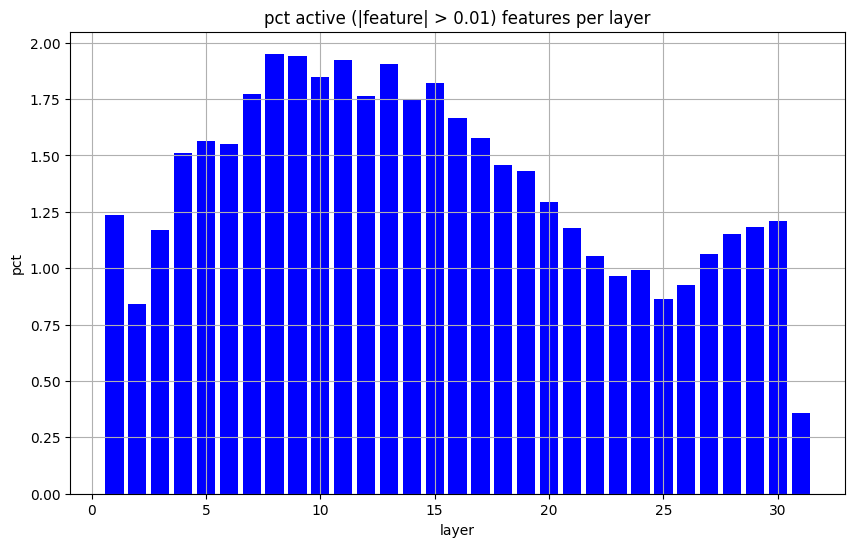

We can see the vector is very sparse--a maximum of just under 2% of features are active in any layer. But that's still much more than the handful of features you'd typically clamp by hand!